## Load Scene Dataset

In [24]:
from timm.data.transforms_factory import create_transform
from timm.data import create_dataset

# create_dataset reads "train" folder and "val" folder.
# the folder name must be matched.
myds = create_dataset(name='', root = '/media/nd-ygr/Data/Image/SceneImage_Intel/sceneimages.tar', transform=create_transform(500), split='train')

image, label = myds[0]
image.shape

torch.Size([3, 500, 500])

In [25]:
import torchvision.transforms as T
from PIL import Image

transform = T.ToPILImage()
imgview = transform(image)
imgview.show()

In [26]:
myds, type(myds)

(<timm.data.dataset.ImageDataset at 0x7fb39b5e9d30>,
 timm.data.dataset.ImageDataset)

In [1]:
from glob import glob

# Dataset Path List
path = "/media/nd-ygr/Data/Image/SceneImage_Intel"

trainset_path = glob(f'{path}/train/*/*.jpg')
valset_path = glob(f'{path}/val/*/*.jpg')
predset_path = glob(f'{path}/pred/*.jpg')

print(len(trainset_path))    #14034
print(len(valset_path))      # 3000
print(len(predset_path))     # 7301

14034
3000
7301


In [2]:
# trainset_path[0]
# '/media/nd-ygr/Data/Image/SceneImage_Intel/train/buildings/1291.jpg'

def get_label(label_path_list):
    labels = []
    for label_path in label_path_list:
        label = label_path.split("/")[-2]
        labels.append(label)
        
    return labels

In [3]:
from torch.utils.data import Dataset

In [4]:
import torch
from PIL import Image

class MyDataset(Dataset):
    
    """
    image_list : 이미지 경로 리스트
    label_list : 이미지 레이블 리스트
    transform = 전처리
    """
    
    def __init__(self, image_list, classes, transform):
        self.image_list = image_list
        self.label_list = get_label(image_list)
        self.classes = classes
        self.transform = transform
        
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, index):
        label = self.label_list[index]
        image_path = self.image_list[index]
        image = Image.open(image_path)
        if self.transform is not None:
            transformed_image = self.transform(image)
        
        return transformed_image, self.classes.index(label)

In [5]:
from torchvision import transforms

class MyTransform():
    
    def __init__(self, size):
        self.image_transform = transforms.Compose(
            [transforms.Resize((size,size), transforms.InterpolationMode.BICUBIC),
             transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        
    def __call__(self, image):
        
        return self.image_transform(image)

In [6]:
# Define Batch Size
batch_size = 12
number_of_labels = 6

# Define Classes
classes = ('buildings', 'forest', 'glacier', 'mountain', 'sea', 'street')

img_size = 150

In [7]:
from torch.utils.data import DataLoader

trainloader = DataLoader(MyDataset(trainset_path, classes, MyTransform(img_size)), batch_size=batch_size, shuffle=True)
print("The number of images in a training set : ", len(trainloader)*batch_size)

valloader = DataLoader(MyDataset(valset_path, classes, MyTransform(img_size)), batch_size=batch_size, shuffle = True)
print(f"The number of images in a validation set : {len(valloader)*batch_size}")

# testloader = 

The number of images in a training set :  14040
The number of images in a validation set : 3000


## Load classification model

In [8]:
import timm

In [9]:
model = timm.create_model('resnet50d', pretrained = True, num_classes = len(classes), global_pool = 'catavgmax')

In [10]:
# fc layer 없는 상태
print("model.get_classifier() : ", model.get_classifier())
num_in_features = model.get_classifier().in_features; num_in_features

model.get_classifier() :  Linear(in_features=4096, out_features=6, bias=True)


4096

In [11]:
import torch
from torch import nn

dropout = 0.4

model.fc = nn.Sequential(
    nn.BatchNorm1d(num_in_features),
    nn.Linear(in_features = num_in_features, out_features = 512, bias = False),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(dropout),
    nn.Linear(in_features = 512, out_features = 6, bias = False))

In [12]:
# 모델의 마지막 레이어에 커스텀 레이어가 적용된 모습을 볼 수 있다.
model.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Co

In [13]:
def validation(model):
    
    total = 0
    accuracy = 0
    
    with torch.no_grad():
        for images, labels in valloader:
            
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
            
        accuracy = (100 * accuracy) / total
        
    return accuracy 

In [14]:
def train(model, num_epochs):
    
    # Convert model parameters and buffers to CPU or Cuda
    model = model.to(device)
    
    loss_fn = nn.CrossEntropyLoss()
    
    from torch.optim import Adam
    optimizer = Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
    
    best_accuracy = 0.0
    
    for epoch in range(num_epochs):
        
        running_loss = 0.0
        
        for i, (images, labels) in enumerate(trainloader, 0):
            
            images = images.to(device)
            labels = labels.to(device)
            # print("labels : ", labels)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            # print(type(outputs))
            # print(outputs)
            # print(outputs.data)
            # _, prediction = torch.max(outputs, 1)
            # print("prediction : ", prediction)
            
            loss = loss_fn(outputs, labels)
            
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item()        
        
        if divmod(epoch+1, 2)[1] == 0:
            val_accuracy = validation(model)
            print("[%3d / %3d] train loss : %.3f, validation accuracy : %.3f" % (epoch+1, num_epochs, running_loss/100, val_accuracy))
            running_loss = 0.0
            
            if val_accuracy > best_accuracy:
                saveModel(model)
                best_accuracy = val_accuracy


In [15]:
def valAccuracy(model):
    
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        
        for val in valloader:
            
            images, labels = val
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
            
        accuracy = (100 * accuracy / total)
        
    return accuracy
            



In [16]:
def saveModel(model):
    path = './timm_result/timm_sceneClassModel.pth'
    torch.save(model.state_dict(), path)

In [17]:
# Define your execution device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")

train(model, 20)

The model will be running on cuda device
[  2 /  20] train loss : 2.033, validation accuracy : 93.033
[  4 /  20] train loss : 1.214, validation accuracy : 93.000
[  6 /  20] train loss : 0.652, validation accuracy : 92.100
[  8 /  20] train loss : 0.499, validation accuracy : 92.767
[ 10 /  20] train loss : 0.424, validation accuracy : 90.500
[ 12 /  20] train loss : 0.410, validation accuracy : 92.833
[ 14 /  20] train loss : 0.294, validation accuracy : 92.933
[ 16 /  20] train loss : 0.389, validation accuracy : 92.800
[ 18 /  20] train loss : 0.366, validation accuracy : 90.533
[ 20 /  20] train loss : 0.341, validation accuracy : 92.900


## Check feature maps


In [7]:
import numpy as np
image = torch.as_tensor(np.array(image, dtype=np.float32)).transpose(0,0)[None]
print(image.shape)

torch.Size([1, 3, 500, 500])


In [8]:
feature_output= model.forward_features(image)

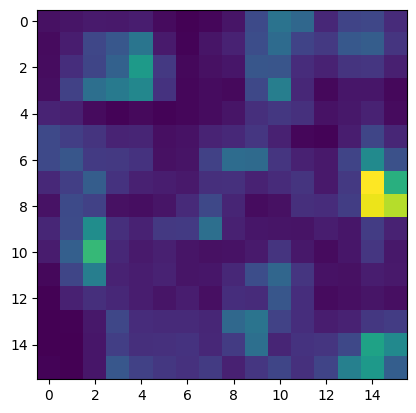

In [9]:
import matplotlib.pyplot as plt
def visualize_feature_output(t):
    plt.imshow(t[0].transpose(0,2).sum(-1).detach().numpy())
    plt.show()
    
visualize_feature_output(feature_output)